In [30]:
import os
import cv2
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt

In [31]:
def load_images_and_extract_features(data_dir, image_size=(512, 512)):
    features = []
    labels = []
    for folder in os.listdir(data_dir):
        folder_path = os.path.join(data_dir, folder)
        if os.path.isdir(folder_path):
            for file in os.listdir(folder_path):
                if file.endswith(".jpeg"):
                    image_path = os.path.join(folder_path, file)
                    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)  # Load as grayscale
                    image = cv2.resize(image, image_size)
                    features.append(image)
                    labels.append(folder)
    features = np.array(features)
    labels = np.array(labels)
    return features, labels

In [32]:
# Function to generate poisoned samples
def generate_poisoned_samples(X, y, num_samples, target_class):
    poisoned_samples = []
    poisoned_labels = []
    for i in range(num_samples):
        index = np.random.randint(0, len(X))
        poisoned_sample = X[index] + np.random.normal(0, 0.1, X[index].shape)
        poisoned_sample = np.clip(poisoned_sample, 0, 1)  # Normalize to range [0, 1]
        poisoned_samples.append(poisoned_sample)
        poisoned_labels.append(target_class)  # Label poisoned samples as the target class
    return np.array(poisoned_samples), np.array(poisoned_labels)

In [33]:
data_dir = "/kaggle/input/images-v1"
X, y = load_images_and_extract_features(data_dir)

# Convert string labels to integers
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.1, random_state=35)

In [34]:
X_train = X_train / 255.0
X_test = X_test / 255.0
X_train = X_train[..., np.newaxis]
X_test = X_test[..., np.newaxis]
target_class = 0 
# Generate poisoned samples
num_poisoned_samples = int(0.1 * len(X_train))  # For example, poison 10% of the training data
poisoned_X, poisoned_y = generate_poisoned_samples(X_train, y_train, num_poisoned_samples, target_class)


In [35]:
X_train_poisoned = np.vstack((X_train, poisoned_X))
y_train_poisoned = np.hstack((y_train, poisoned_y))

In [36]:
def create_simple_model():
    input_layer = layers.Input(shape=(512, 512, 1))
    conv1 = layers.Conv2D(32, (3, 3), activation='relu')(input_layer)
    pool1 = layers.MaxPooling2D((2, 2))(conv1)
    conv2 = layers.Conv2D(64, (3, 3), activation='relu')(pool1)
    pool2 = layers.MaxPooling2D((2, 2))(conv2)
    flatten = layers.Flatten()(pool2)
    dense1 = layers.Dense(64, activation='relu')(flatten)
    output = layers.Dense(len(np.unique(y_encoded)), activation='softmax')(dense1)
    model = models.Model(inputs=input_layer, outputs=output)
    model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    return model

In [37]:
simple_model = create_simple_model()
history = simple_model.fit(X_train_poisoned, y_train_poisoned, epochs=10, validation_data=(X_test, y_test))

# Evaluate the simpler model on the original test set
test_loss, test_accuracy = simple_model.evaluate(X_test, y_test)
print("Test Accuracy after poisoning:", test_accuracy)

Epoch 1/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 97s 7s/step - accuracy: 0.0278 - loss: 19.4735 - val_accuracy: 0.1500 - val_loss: 2.7373
Epoch 2/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 94s 7s/step - accuracy: 0.2994 - loss: 2.5239 - val_accuracy: 0.5750 - val_loss: 1.6264
Epoch 3/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 94s 7s/step - accuracy: 0.6692 - loss: 1.3283 - val_accuracy: 0.5750 - val_loss: 1.5157
Epoch 4/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 93s 7s/step - accuracy: 0.7665 - loss: 0.8776 - val_accuracy: 0.6000 - val_loss: 1.3884
Epoch 5/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 93s 7s/step - accuracy: 0.8805 - loss: 0.4805 - val_accuracy: 0.5500 - val_loss: 1.7282
Epoch 6/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 142s 7s/step - accuracy: 0.8920 - loss: 0.4846 - val_accuracy: 0.6500 - val_loss: 1.1894
Epoch 7/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 142s 7s/step - accuracy: 0.9329 - loss: 0.2141 - val_accuracy: 0.6500 - val_loss: 1.3006
Epoch 8/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 97s 7s/step - accuracy: 0.9780 - loss: 0.0890 - val_accuracy: 0.7250 - val_lo

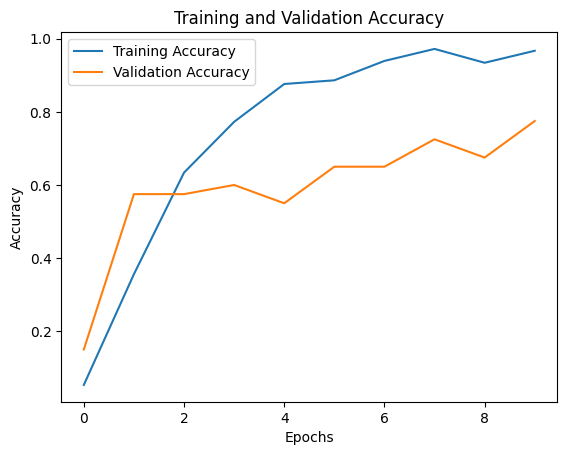

In [38]:
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()

In [39]:
# Function to display images and predictions
def display_images_and_predictions(model, original_images, poisoned_images, label_encoder):
    fig, axes = plt.subplots(2, len(original_images), figsize=(20, 5))
    for i, (original, poisoned) in enumerate(zip(original_images, poisoned_images)):
        # Original image
        axes[0, i].imshow(original.squeeze(), cmap='gray')
        original_prediction = model.predict(np.expand_dims(original, axis=0))
        original_label = label_encoder.inverse_transform([np.argmax(original_prediction)])
        axes[0, i].set_title(f'Original: {original_label[0]}')
        axes[0, i].axis('off')
        
        # Poisoned image
        axes[1, i].imshow(poisoned.squeeze(), cmap='gray')
        poisoned_prediction = model.predict(np.expand_dims(poisoned, axis=0))
        poisoned_label = label_encoder.inverse_transform([np.argmax(poisoned_prediction)])
        axes[1, i].set_title(f'Poisoned: {poisoned_label[0]}')
        axes[1, i].axis('off')
    plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step


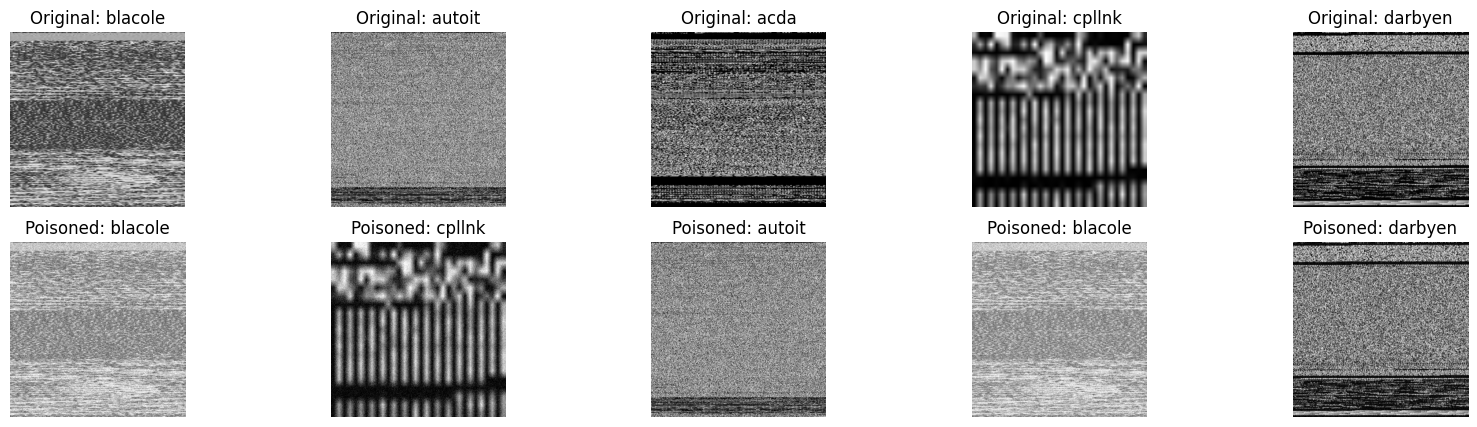

In [40]:
num_display = 5
indices = np.random.choice(len(X_test), num_display, replace=False)
original_images = X_test[indices]
poisoned_images, _ = generate_poisoned_samples(original_images, y_test[indices], num_display, target_class)

# Display images and predictions
display_images_and_predictions(simple_model, original_images, poisoned_images, label_encoder)